# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Axel Escoto García

**Professor**: Pablo Camarillo Ramirez

# Introduction
Para el proyecto decidí cambiar de concepto por uno que contiene informacion de ventas semanales por tiendas de Walmart. Mediante este dataset podemos generar agregaciones que permitan obtener datos relevantes, como epocas malas, rendimiento de tiendas

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Walmart Sales - Batch Proyect") \
    .master("spark://spark-master:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

25/10/27 01:17:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# Dataset
Sourced from Kaggle: https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data

In [2]:
from axel2293.spark_utils import SparkUtils

# Define the schema

sh = [
    ("store", "int"),
    ("date", "string"),
    ("weekly_sales", "double"),
    ("is_holiday", "int"),
    ("temp", "double"),
    ("fuel_price", "double"),
    ("cpi", "double"),
    ("unemployment", "double")
]

sales_schema = SparkUtils.generate_schema(sh)

sales_schema

StructType([StructField('store', IntegerType(), True), StructField('date', StringType(), True), StructField('weekly_sales', DoubleType(), True), StructField('is_holiday', IntegerType(), True), StructField('temp', DoubleType(), True), StructField('fuel_price', DoubleType(), True), StructField('cpi', DoubleType(), True), StructField('unemployment', DoubleType(), True)])

In [12]:
# Read the csv and create the df
df_sales = spark.read \
                .option("header", "true") \
                .schema(sales_schema) \
                .csv("/opt/spark/work-dir/data/walmart_sales")
df_sales.printSchema()

root
 |-- store: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- weekly_sales: double (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- fuel_price: double (nullable = true)
 |-- cpi: double (nullable = true)
 |-- unemployment: double (nullable = true)



In [4]:
!ls ../../data/walmart_sales
!pwd


Walmart_Sales.csv
/opt/spark/work-dir/final_project/batch_processing


# Transformations and Actions

In [10]:
from pyspark.sql.functions import col, count, sum, avg, to_date, isnull, when, year, month, weekofyear

# Get NULL values
df_sales.select([count(when(isnull(c[0]) | col(c[0]).isNull(), c[0])).alias(c[0]) for c in sh]).show()

df_sales = df_sales.dropna()

# Format date field to correct type
df_sales = df_sales.withColumn("date", to_date(col("date"), "dd-MM-yyyy"))

# Add derived date columns
df_sales = (
    df_sales
    .withColumn("year", year("date"))
    .withColumn("month", month("date"))
    .withColumn("week", weekofyear("date"))
)

# Add flag to indicate if sales where high
if 'weekly_sales' in df_sales.columns:
    df_sales = df_sales.withColumn('high_sales_flag', when(col('weekly_sales') > 1_300_000, 1).otherwise(0))

cols_order = ['store','date','year','month','week','weekly_sales','high_sales_flag','is_holiday','temp','fuel_price','cpi','unemployment']
cols_present = [c for c in cols_order if c in df_sales.columns]
df_sales = df_sales.select(*cols_present)

df_sales.printSchema()

+-----+----+------------+----------+----+----------+---+------------+
|store|date|weekly_sales|is_holiday|temp|fuel_price|cpi|unemployment|
+-----+----+------------+----------+----+----------+---+------------+
|    0|   0|           0|         0|   0|         0|  0|           0|
+-----+----+------------+----------+----+----------+---+------------+

root
 |-- store: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- weekly_sales: double (nullable = true)
 |-- high_sales_flag: integer (nullable = false)
 |-- is_holiday: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- fuel_price: double (nullable = true)
 |-- cpi: double (nullable = true)
 |-- unemployment: double (nullable = true)



## Aggregations

In [6]:
# Some Aggregations

# Sales per store - Order by total of sales desc
store_sales = df_sales.groupBy("store") \
                    .agg(sum("weekly_sales") \
                    .alias("total_sales")) \
                    .orderBy(col("total_sales").desc())

# Average sales per month - Order by year, then month
monthly_avg = df_sales.groupBy("year", "month") \
    .agg(avg("weekly_sales") \
    .alias("avg_weekly_sales")) \
    .orderBy("year", "month")

# Avg sales on holidays vs non-holidays
holiday_comparison = df_sales.groupBy("is_holiday") \
    .agg(avg("weekly_sales") \
    .alias("avg_sales"))

store_sales.show()
monthly_avg.show()
holiday_comparison.show()

+-----+--------------------+
|store|         total_sales|
+-----+--------------------+
|   20|3.0139779246000004E8|
|    4|      2.9954395338E8|
|   14|2.8899991134000003E8|
|   13|2.8651770380000013E8|
|    2| 2.753824409800001E8|
|   10| 2.716177138899999E8|
|   27|2.5385591688000003E8|
|    6|2.2375613064000002E8|
|    1|2.2240280885000005E8|
|   39|2.0744554246999997E8|
|   19|       2.066348621E8|
|   31|1.9961390549999997E8|
|   23| 1.987506178499999E8|
|   24|1.9401602127999994E8|
|   11|1.9396278679999992E8|
|   28|1.8926368057999986E8|
|   41|1.8134193488999993E8|
|   32|1.6681924616000003E8|
|   18|      1.5511473421E8|
|   22|1.4707564857000002E8|
+-----+--------------------+
only showing top 20 rows
+----+-----+------------------+
|year|month|  avg_weekly_sales|
+----+-----+------------------+
|2010|    2|1057405.4613333333|
|2010|    3|1010665.5694444445|
|2010|    4| 1028499.413555556|
|2010|    5|1037282.9685555558|
|2010|    6|1068034.2908888892|
|2010|    7|1033689.448

# Persistence Data

## Parquet format
Partition by year and month

In [11]:
output_path = "/opt/spark/work-dir/data/processed/walmart_sales_parquet/"
(df_sales
    .repartition(5)
    .write
    .mode('overwrite')
    .partitionBy('year','month')
    .parquet(output_path))

print("DF written in parquet format")

[Stage 23:==============================================>           (4 + 1) / 5]

DF written in parquet format


## Postgres store

In [8]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
table_name = "walmart_sales_transformed"

df_sales.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .mode("overwrite") \
    .save()

print("Df written on the PostgreSQL DB")

[Stage 16:>                                                         (0 + 1) / 1]

Df written on the PostgreSQL DB


In [9]:
db_properties = {
      "user": "postgres",      
      "password": "Admin@1234",
      "driver": "org.postgresql.Driver"
  }

df_sales_db = spark.read \
    .jdbc(url=jdbc_url, table=table_name, properties=db_properties)

df_sales_db.printSchema()
df_sales_db.show(5, truncate=False)


root
 |-- store: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- weekly_sales: double (nullable = true)
 |-- high_sales_flag: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- fuel_price: double (nullable = true)
 |-- cpi: double (nullable = true)
 |-- unemployment: double (nullable = true)

+-----+----------+----+-----+----+------------+---------------+----------+-----+----------+-----------+------------+
|store|date      |year|month|week|weekly_sales|high_sales_flag|is_holiday|temp |fuel_price|cpi        |unemployment|
+-----+----------+----+-----+----+------------+---------------+----------+-----+----------+-----------+------------+
|1    |2010-02-05|2010|2    |5   |1643690.9   |1              |0         |42.31|2.572     |211.0963582|8.106       |
|1    |2010-02-12|2010|2    |6   |1641957.44  |1  

# DAG
## JDBC
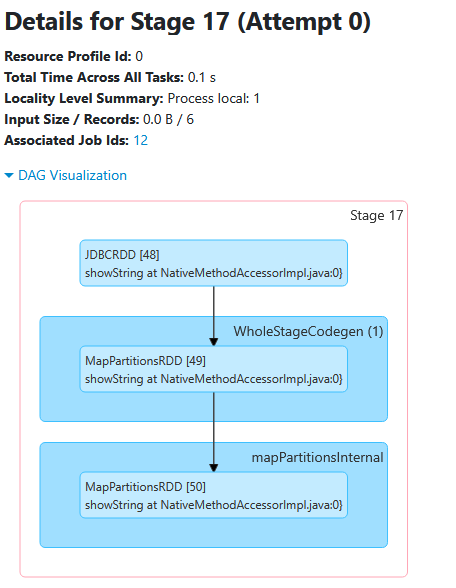
## PARQUET
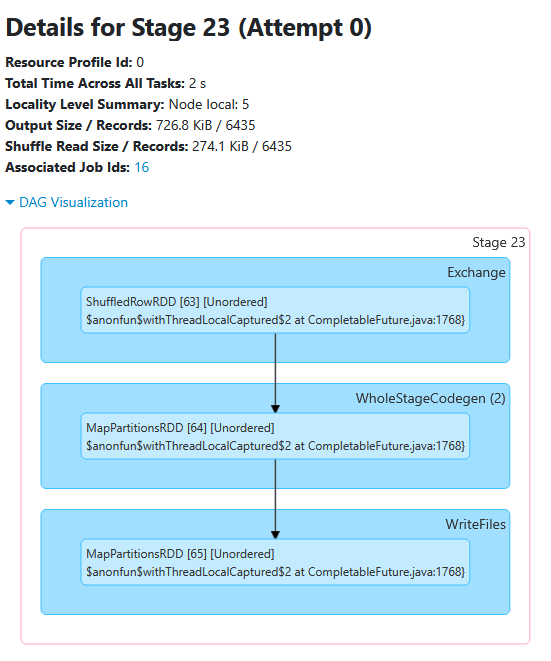